# Risk and strategy I

In trading and investment, risk is an inherent property that comes with the dealings of any security: it gives the potential of gain or loss in financial value. Not every aspect of risk behaves the same way, and in the long run we want to minimise risks while maximising gains. Trading in a free market is a zero-sum game, but this does not mean we cannot profit in the long run.

## Beta hedging

*Hedging* is a way of mitigating risk, by using a combination of assets. *Beta* is the measure of one asset's movement relative to another. More precisely, in a *factor model*
$$
Y=\alpha+\beta_1 X_1 + \beta_2 X_2 + ...\,,
$$
the Betas of an asset $Y$ are simply the coefficients $\beta_i$ of the relative assets $X_i$ in the model. 

In [1]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

sns.set_style(  
    "whitegrid",  
    {  
        'legend.frameon': True,  
    }  
)
matplotlib.rc('figure', figsize=(14, 8))

Let us quickly regress an asset and benchmark to find the coefficients $\alpha$ and $\beta$.

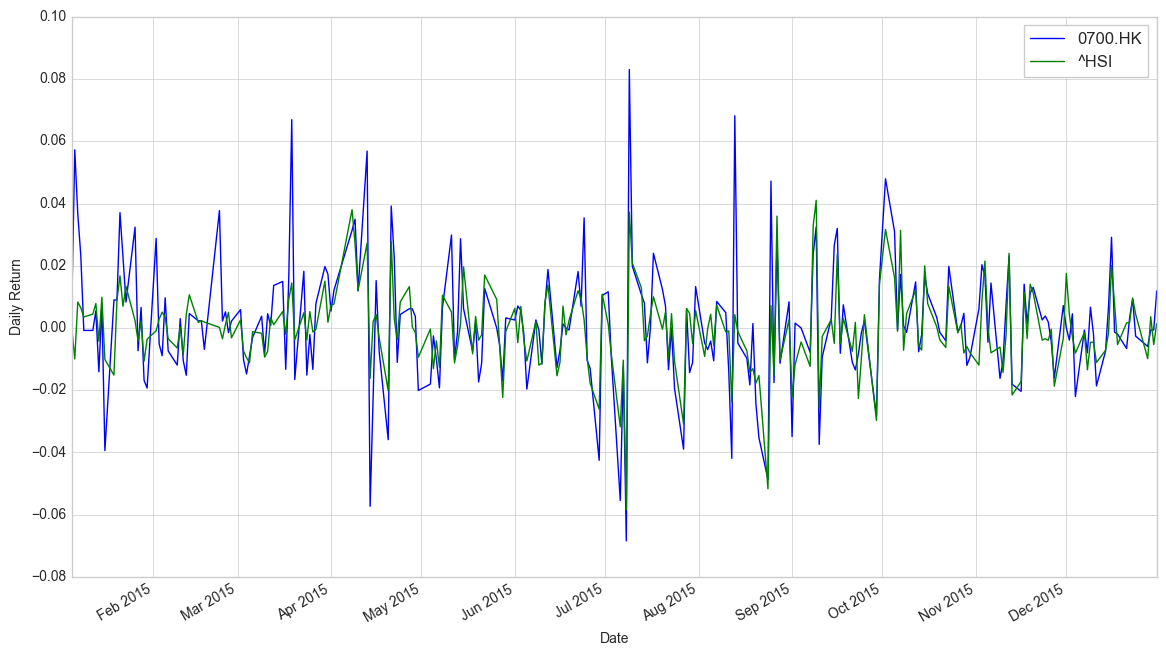

In [2]:
import finance.utils as ut

start = "2015-01-01"
end = "2015-12-31"

asset = ut.get_pricing("0700.HK", "yhoo", start, end, field="close").dropna()
benchmark = ut.get_pricing("^HSI", "yhoo", start, end, field="close").dropna()

r_a = asset.pct_change()[1:]
r_b = benchmark.pct_change()[1:]

ax=r_a.plot()
r_b.plot(ax=ax)
plt.ylabel("Daily Return")
plt.legend();

alpha: 0.00169316671116
beta: 1.14545581395


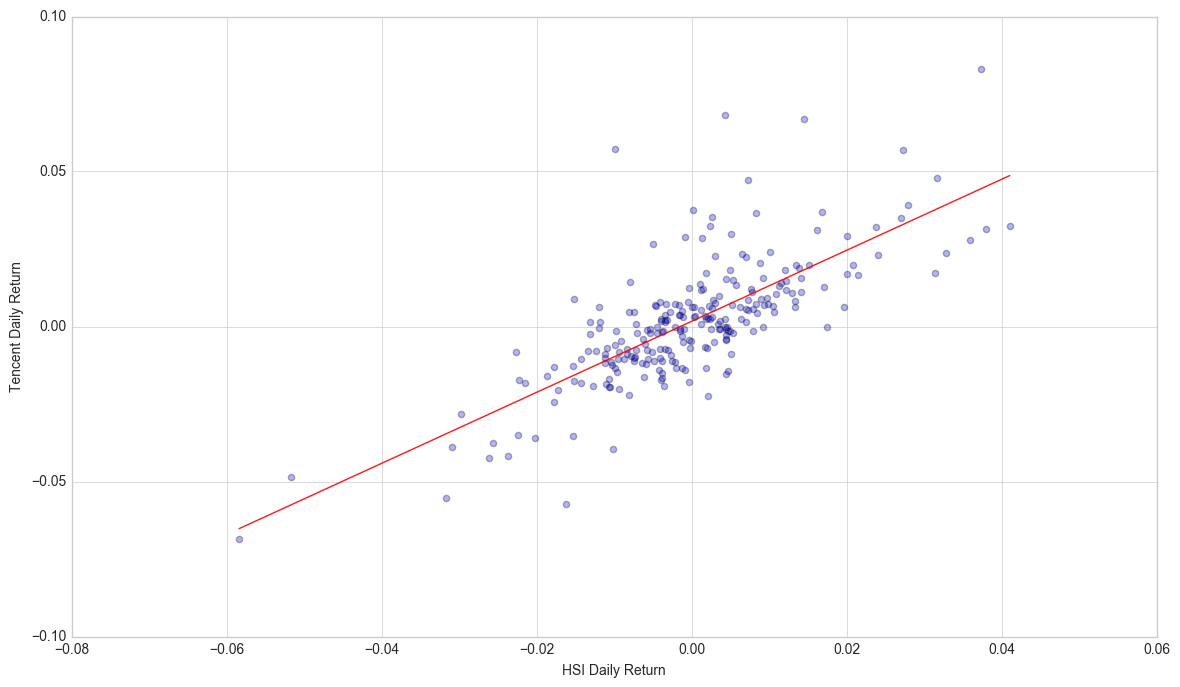

In [3]:
from statsmodels import regression

# Let's define everything in familiar regression terms
X = r_b.values # Get just the values, ignore the timestamps
Y = r_a.values

def linreg(x,y):
    # We add a constant so that we can also fit an intercept (alpha) to the model
    # This just adds a column of 1s to our data
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    # Remove the constant now that we're done
    x = x[:, 1]
    return model

model = linreg(X,Y)
alpha = model.params[0]
beta = model.params[1]
print 'alpha: ' + str(alpha)
print 'beta: ' + str(beta)

X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2 * beta + alpha

plt.scatter(X, Y, alpha=0.3) # Plot the raw data
plt.xlabel("HSI Daily Return")
plt.ylabel("Tencent Daily Return")

 # Add the regression line, colored in red
plt.plot(X2, Y_hat, 'r', alpha=0.9)

The beta can sometimes be interpreted as the amount of risk exposure we take on by holding the particular asset. If an asset has a high beta exposure to the market index, then while it will do very well when the market is rising, it will also do very poorly when the market falls. Hence a high beta corresponds to high speculative risk.

We will aim to keep our beta exposure as low as possible. This means is that all of the returns in a strategy lie in the $\alpha$ portion of the model, and are independent of other factors. It will allow us to profit regardless of whether the market is bullish or bearish.

Suppose our portfolio's returns are dependent on the market via the relation
$$
Y_\text{portfolio}=\alpha+\beta X_\text{HSI}\,.
$$
We can then take a short position on HSI to try to cancel out this risk, by shorting an amount $\beta V$ for $V$ the total value of our portfolio. The combined returns then cancels out the second term in the equation above. This sort of strategy is called *market neutral*. Note that the beta is not constant in time and so in practice it is difficult to reduce the beta by a significant amount.

Let us now try to create our hedged portfolio and see how it affects our returns.

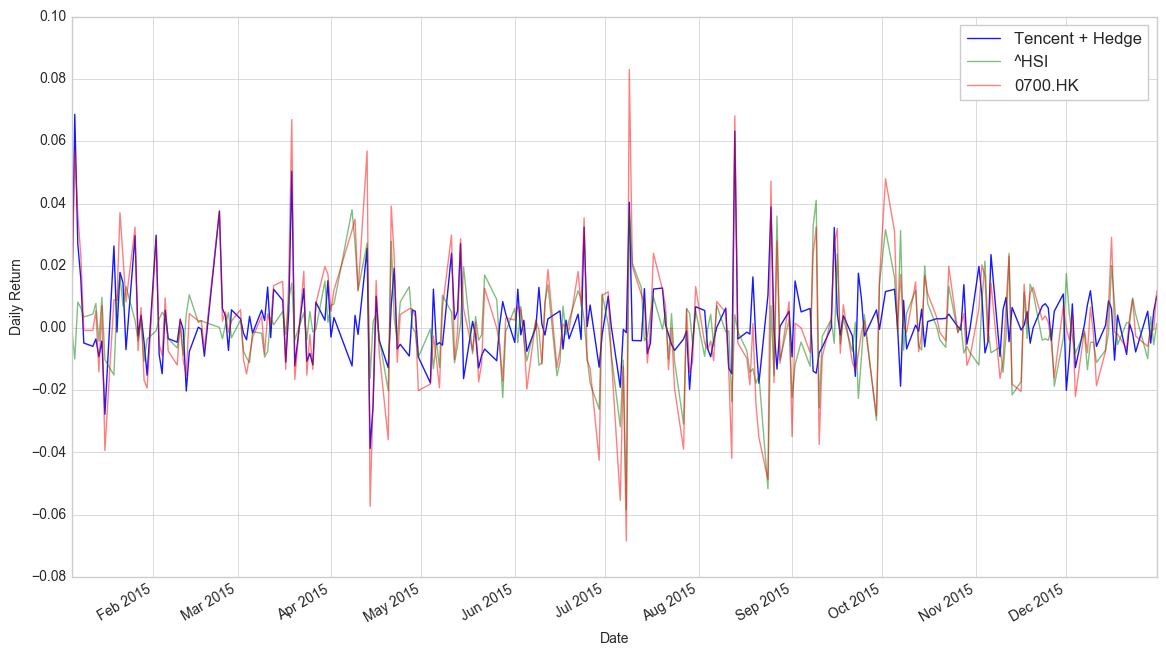

In [4]:
# Construct a portfolio with beta hedging
portfolio = -1*beta*r_b + r_a
portfolio.name = "Tencent + Hedge"

# Plot the returns of the portfolio as well as the asset by itself
ax=portfolio.plot(alpha=0.9)
r_b.plot(alpha=0.5,ax=ax);
r_a.plot(alpha=0.5,ax=ax);
plt.ylabel("Daily Return")
plt.legend();

Let us compare their performances (mean returns) and volatilities (standard deviations of returns) and see if they have changed. We should see that the volatility has decreased at the expense of some returns. Let us also check that the beta has been eliminated.

In [5]:
print "means (portfolio vs asset): ", portfolio.mean(), r_a.mean()
print "volatilities (portfolio vs asset): ", portfolio.std(), r_a.std()

P = portfolio.values
h_model = linreg(X,P)
h_alpha = model.params[0]
h_beta = model.params[1]
print 'hedged alpha: ' + str(h_alpha)
print 'hedged beta: ' + str(h_beta)

means (portfolio vs asset):  0.00169316671116 0.00142136273895
volatilities (portfolio vs asset):  0.0130540115944 0.0198307866894
hedged alpha: 0.00169316671116
hedged beta: 1.14545581395


Let us now test our portfolio on out-of-sample data. 

Asset Historical Estimate:
alpha: 0.00169316671116
beta: 1.14545581395
Asset Out of Sample Estimate:
alpha: 0.00167050366026
beta: 1.03345867127
Portfolio Out of Sample:
alpha: 0.00167050366026
beta: -0.111997142681


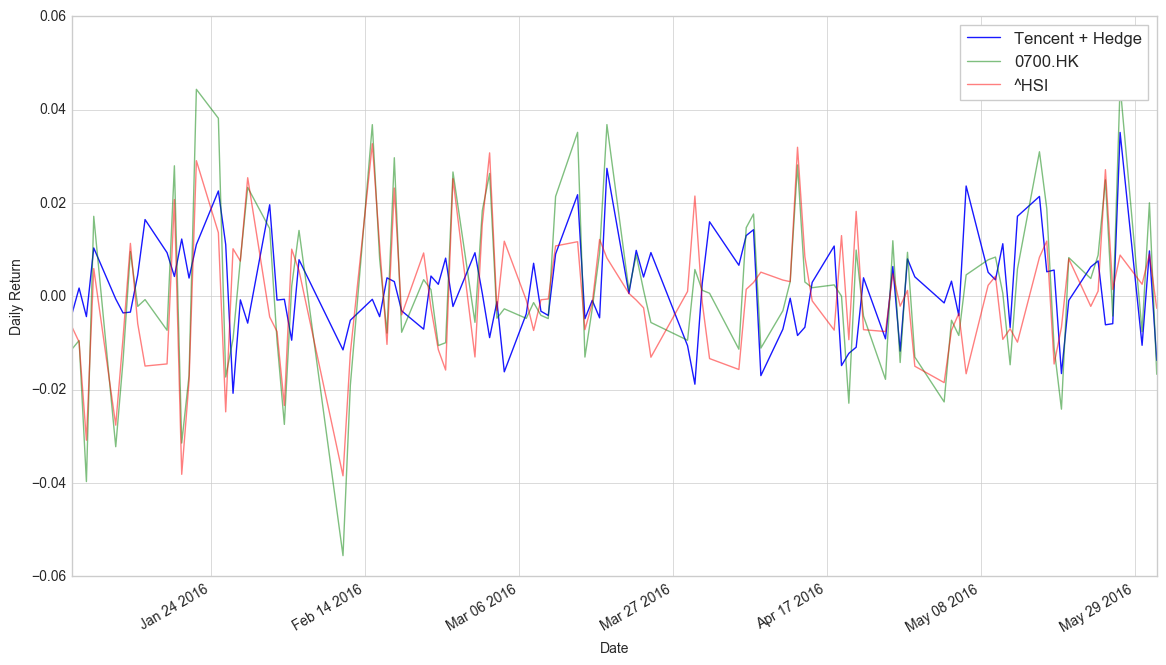

In [6]:
# Get the alpha and beta estimates over the last year
start = '2015-01-01'
end = '2015-12-31'
asset = ut.get_pricing('0700.HK', src="yhoo", start_date=start, end_date=end, field='close').dropna()
benchmark = ut.get_pricing('^HSI',src="yhoo", start_date=start, end_date=end, field='close').dropna()
r_a = asset.pct_change()[1:]
r_b = benchmark.pct_change()[1:]
X = r_b.values
Y = r_a.values
model = linreg(X,Y)
historical_alpha = model.params[0]
historical_beta = model.params[1]
print 'Asset Historical Estimate:'
print 'alpha: ' + str(historical_alpha)
print 'beta: ' + str(historical_beta)

# Get data for a different time frame:
start = '2016-01-01'
end = '2016-06-01'
asset = ut.get_pricing('0700.HK', src="yhoo", start_date=start, end_date=end, field='close').dropna()
benchmark = ut.get_pricing('^HSI',src="yhoo", start_date=start, end_date=end, field='close').dropna()

# Repeat the process from before to compute alpha and beta for the asset
r_a = asset.pct_change()[1:]
r_b = benchmark.pct_change()[1:]
X = r_b.values
Y = r_a.values
model = linreg(X,Y)
alpha = model.params[0]
beta = model.params[1]
print 'Asset Out of Sample Estimate:'
print 'alpha: ' + str(alpha)
print 'beta: ' + str(beta)

# Create hedged portfolio and compute alpha and beta
portfolio = -1*historical_beta*r_b + r_a
P = portfolio.values
model = linreg(X,P)
alpha = model.params[0]
beta = model.params[1]
print 'Portfolio Out of Sample:'
print 'alpha: ' + str(alpha)
print 'beta: ' + str(beta)


# Plot the returns of the portfolio as well as the asset by itself
portfolio.name = "Tencent + Hedge"
ax=portfolio.plot(alpha=0.9)
r_a.plot(alpha=0.5,ax=ax);
r_b.plot(alpha=0.5,ax=ax)
plt.ylabel("Daily Return")
plt.legend();

As we can see, the beta estimate changes a good deal when we look at the out of sample estimate. Our hedged portfolio still does not do too badly, however.

As mentioned above, the trade-off in hedging against a benchmark such as the market is that it will reduce your returns while the market is not doing poorly. This is, however, more desirable since your algorithm is less volatile. We can then take out leverage on your strategy and multiply your returns back up to their original amount. Even better, your returns will be far more stable than the original volatile beta exposed strategy.

By and large, even though high-beta strategies tend to be deceptively attractive due to their extremely good returns during periods of market growth, they fail in the long term as they will suffer extreme losses during a downturn.

## Pairs trading
Pairs trading is a classic example of a strategy based on mathematical analysis. The principle is as follows. Suppose we have a pair of securities X and Y that have some underlying economic link. For example, there might be two companies that manufacture the same product, or two companies in one supply chain. If we can model this economic link with a mathematical model, we can make trades on it.

In [7]:
# imports
import statsmodels
from statsmodels.tsa.stattools import coint

Let us start by generating two "fake" securities. We model $X$'s daily returns by drawing from a normal distribution. We then perform a cumulative sum to get the value of $X$ on each day. Next we create $Y$, a security that supposedly has some economic link with $X$. We model this by taking $X$, shifting it up and adding some random noise drawn from a normal distribution.

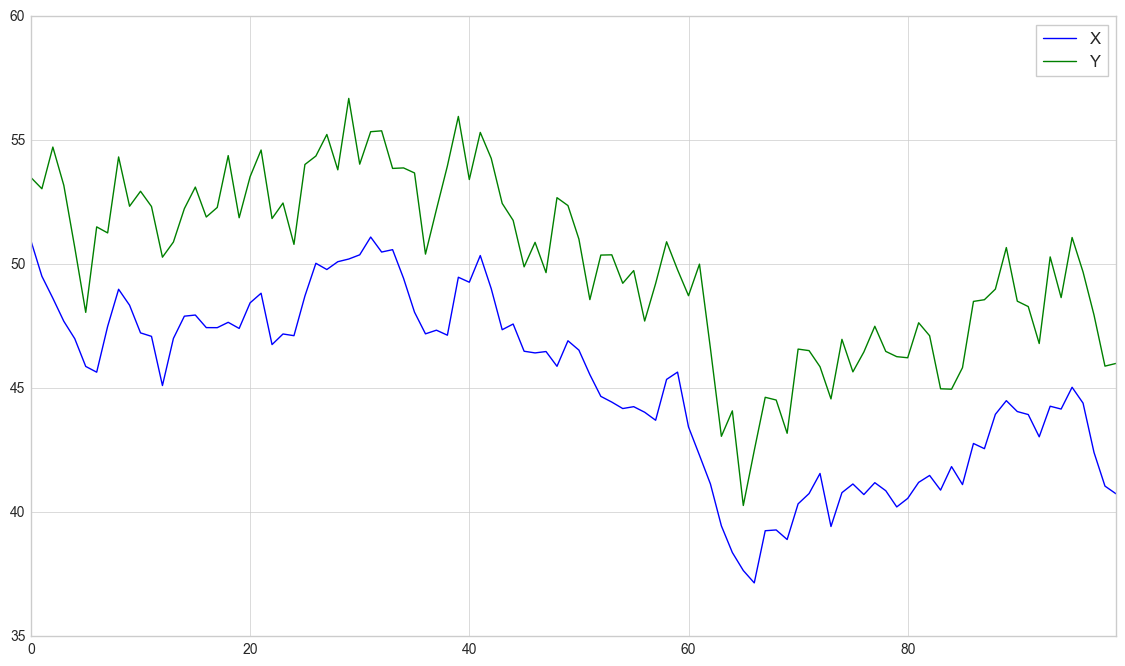

In [8]:
X_returns = np.random.normal(0, 1, 100) # Generate the daily returns
# sum them and shift all the prices up into a reasonable range
X = pd.Series(np.cumsum(X_returns), name='X') + 50

some_noise = np.random.normal(0, 1, 100)
Y = X + 5 + some_noise
Y.name = 'Y'
pd.concat([X, Y], axis=1).plot();

We say that these two series are *cointegrated*. This means that there is some linear combination between them that will vary around a mean.  At all points in time, the combination between them is related to the same probability distribution. To test for cointegration, we can use the `coint()` function in `statsmodels.tsa.stattools`. We should then get a p-value below a particular cutoff, say 0.05.

In [9]:
# compute the p-value of the cointegration test
# will inform us as to whether the spread between the 2 timeseries is stationary
# around its mean
score, pvalue, _ = coint(X,Y)
print pvalue

0.631921928435


Note that a cointegrated series may not be correlated, and vice-versa. An example is two diverging series.

Correlation: 0.99208767066
Cointegration test p-value: 0.706193210952


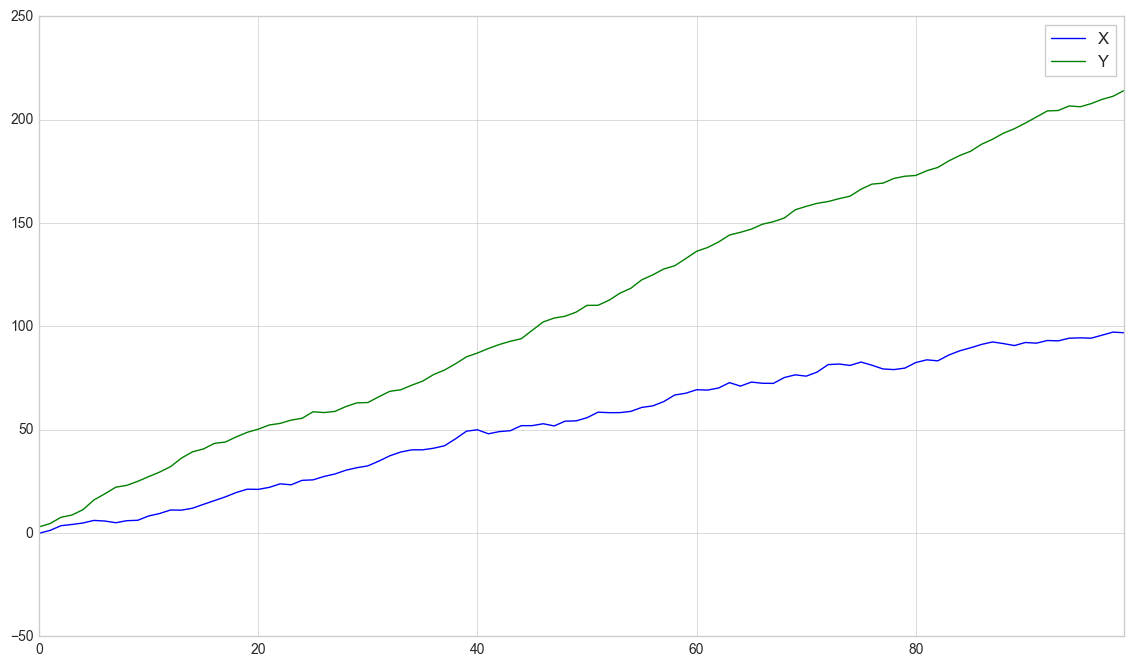

In [10]:
X_returns = np.random.normal(1, 1, 100)
Y_returns = np.random.normal(2, 1, 100)

X_diverging = pd.Series(np.cumsum(X_returns), name='X')
Y_diverging = pd.Series(np.cumsum(Y_returns), name='Y')

print 'Correlation: ' + str(X_diverging.corr(Y_diverging))
score, pvalue, _ = coint(X_diverging,Y_diverging)
print 'Cointegration test p-value: ' + str(pvalue)
pd.concat([X_diverging, Y_diverging], axis=1).plot();

Pairs trading utilises this cointegrated relationship between $X$ and $Y$ to make money on their spread. Since we know that if the two are far apart, they will try to revert back to the mean, by maintaining a hedged position on the two (short one and long the other), we can make a profit on the difference. For example, when the spread is small we expect it to become larger (*long* the spread), so we place a bet on this by longing $Y$ and shorting $X$. Conversely, when the spread is large we expect it to become smaller. So we short $Y$ and long $X$ (*short* the spread).

Let us now try to look for cointegration in pairs of stocks. To avoid falling to multiple comparisons bias, we should only do this on securities that we suspect might have some cointegration.

In [11]:
# Extract list of CN developer stocks from a research report page on AAstocks
a = "AGILE GROUP (03383.HK)  +0.320 (+2.787%)    Short selling $32.15M; Ratio 9.471%   /Neutral/9.2 BJ CAPITAL LAND (02868.HK)  +0.030 (+0.651%)    Short selling $524.28K; Ratio 1.725%   /Buy/5.18CHI MER LAND (00978.HK)  +0.030 (+1.807%)    Short selling $155.48K; Ratio 0.344%   /Buy/1.8CHINA SCE PPT (01966.HK)  -0.110 (-2.439%)    Short selling $440.79K; Ratio 0.278%   /Buy*/5.18CIFI HOLD GP (00884.HK)  +0.250 (+5.376%)    Short selling $7.64M; Ratio 2.865%   /Buy*/5.12CH OVS G OCEANS (00081.HK)  +0.020 (+0.365%)    Short selling $1.27M; Ratio 1.348%   /Buy*/6.1CHINA OVERSEAS (00688.HK)  +0.550 (+2.015%)    Short selling $128.41M; Ratio 11.851%   /Buy/33.8COUNTRY GARDEN (02007.HK)  +0.780 (+6.103%)    Short selling $260.74M; Ratio 14.271%   /Buy/13.38CHINA RES LAND (01109.HK)  +0.200 (+0.800%)    Short selling $68.82M; Ratio 16.034%   /Buy/30.0EVERGRANDE (03333.HK)  +0.950 (+3.682%)    Short selling $78.30M; Ratio 3.402%   /Buy*/27.35FANTASIA (01777.HK)  +0.060 (+5.556%)    Short selling $25.65K; Ratio 0.085%   /Buy/1.5GREENLAND HK (00337.HK)  +0.040 (+1.299%)    Short selling $1.12M; Ratio 2.069%   /Buy/3.28GREENTOWN CHINA (03900.HK)  +0.140 (+1.378%)    Short selling $19.51M; Ratio 12.253%   /Sell/7R&F PROPERTIES (02777.HK)  +0.080 (+0.429%)    Short selling $15.07M; Ratio 4.764%   /Buy/23.8HOPSON DEV HOLD(00754.HK)  +0.340 (+4.558%)    Short selling $155.42K; Ratio 0.280%   /Sell/6.54CHINA JINMAO (00817.HK)  +0.110 (+2.619%)    Short selling $15.65M; Ratio 6.930%   /Buy/5.68JOY CITY PPT (00207.HK)  +0.050 (+3.472%)    Short selling $11.74K; Ratio 0.039%   /Neutral*/1.45KWG PROPERTY (01813.HK)  +0.400 (+4.768%)    Short selling $31.30M; Ratio 14.885%   /Buy/9.0LOGAN PPT (03380.HK)  +0.660 (+8.281%)    Short selling $38.37M; Ratio 10.024%   /Buy*/8.88LONGFOR PPT (00960.HK)  +0.940 (+4.781%)    Short selling $14.97M; Ratio 7.735%   /Buy/22.38POLY PROPERTY (00119.HK)  +0.030 (+0.683%)    Short selling $556.39K; Ratio 0.633%   /Neutral*/3.5POWERLONG (01238.HK)  +0.110 (+2.764%)    Short selling $1.90M; Ratio 5.844%   /Buy/4.7RS MACALLINE (01528.HK)  0.000 (0.000%)    Short selling $1.62M; Ratio 6.674%   /Neutral/9.45SHENZHEN INVEST (00604.HK)  +0.070 (+1.913%)    Short selling $4.36M; Ratio 2.225%   /Buy/5.1SHIMAO PROPERTY (00813.HK)  +0.440 (+2.709%)    Short selling $8.48M; Ratio 3.443%   /Neutral/15SINO-OCEAN GP (03377.HK)  +0.110 (+2.107%)    Short selling $7.87M; Ratio 3.272%   /Buy/6.25SOHO CHINA (00410.HK)  -0.020 (-0.405%)    Short selling $15.51M; Ratio 13.927%   /Neutral/4.38SUNAC (01918.HK)  +3.700 (+12.416%)    Short selling $241.92M; Ratio 12.552%   /Buy*/31.8TIMES PPT (01233.HK)  +0.070 (+0.960%)    Short selling $1.21M; Ratio 6.764%   /Buy*/7.2YUEXIU PROPERTY (00123.HK)  +0.100 (+6.536%)    Short selling $1.98M; Ratio 0.717%   /Sell*/1.2YUEXIU REIT (00405.HK)  +0.020 (+0.394%)    Short selling $50.75K; Ratio 0.237%   /Buy/5.63YUZHOU PPT (01628.HK)  +0.090 (+1.856%)   /Buy*/6.0"

symbol_list = [el[1:8] for el in a.split('(')[1::2]]
symbol_list.append("^HSI")

In [12]:
prices = ut.get_pricing(symbol_list, src="yhoo", start_date='2014-01-01', end_date='2015-01-01', field='close').dropna()
prices.head()

Could not read data from 0884.HK, skipping
Could not read data from 2777.HK, skipping
Could not read data from 3380.HK, skipping
Could not read data from 1528.HK, skipping
Could not read data from 0813.HK, skipping
Could not read data from 3377.HK, skipping
Could not read data from 0405.HK, skipping
Could not read data from 1628.HK, skipping


,0081.HK,0119.HK,0123.HK,0207.HK,0337.HK,0410.HK,0604.HK,0688.HK,0754.HK,0817.HK,...,1777.HK,1813.HK,1918.HK,1966.HK,2007.HK,2868.HK,3333.HK,3383.HK,3900.HK,^HSI
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,7.31,4.13,1.77206,1.97,3.66,6.68,2.89,21.641399,9.27,2.68,...,1.34,4.36,4.79,1.83,4.62166,2.68,2.94,8.02679,11.80,23340.050781
2014-01-03,7.19,4.09,1.73456,1.93,3.59,6.69,2.83,21.196699,9.16,2.58,...,1.37,4.40,4.67,1.82,4.59210,2.68,2.88,7.98834,11.36,22817.279297
2014-01-06,6.99,3.96,1.70643,1.88,3.60,6.43,2.77,20.653200,9.02,2.46,...,1.37,4.14,4.49,1.79,4.54283,2.67,2.83,7.97873,11.02,22684.150391
2014-01-07,6.77,3.91,1.66892,1.90,3.85,6.34,2.74,20.109699,9.11,2.44,...,1.33,4.15,4.49,1.75,4.39502,2.65,2.85,7.70957,10.76,22712.779297
2014-01-08,6.92,4.07,1.70643,1.97,4.62,6.34,2.79,21.443701,9.16,2.52,...,1.34,4.29,4.78,1.78,4.53298,2.66,2.86,7.71918,11.08,22996.589844


[('0081.HK', '2007.HK'), ('0119.HK', '0337.HK'), ('0410.HK', '0754.HK'), ('0960.HK', '1233.HK'), ('0960.HK', '1238.HK'), ('0960.HK', '1966.HK'), ('0960.HK', '2868.HK'), ('1109.HK', '2868.HK'), ('1233.HK', '1777.HK')]


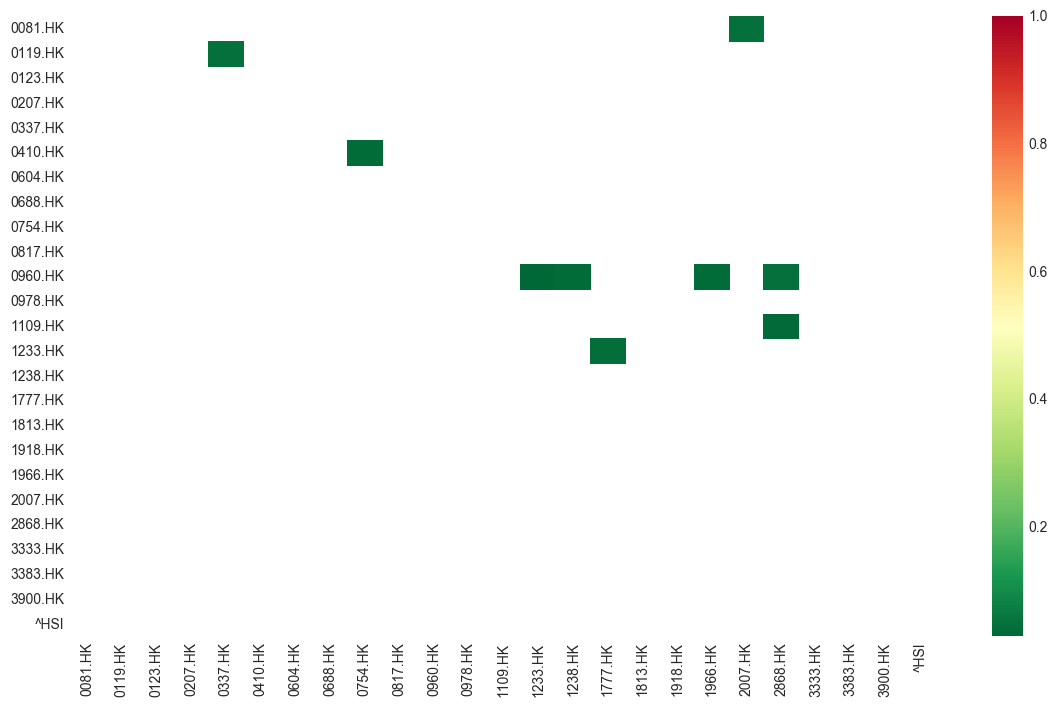

In [13]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

scores, pvalues, pairs = find_cointegrated_pairs(prices)
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
sns.heatmap(pvalues, xticklabels=prices.keys(), yticklabels=prices.keys(), cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.05)
                )
print pairs

Out of these CN Developers, it seems that we have quite a few that are cointegrated. Let us choose 1966.HK (China SCE ppt) and 0960.HK (Longfor ppt).

In [14]:
S1 = prices['0960.HK']
S2 = prices['1966.HK']
score, pvalue, _ = coint(S1, S2)
pvalue

0.039969071157816061

Now we will plot the spread of the two series. In order to actually calculate the spread, we use a linear regression to get the coefficient for the linear combination to construct between our two securities. This method is known as the Engle-Granger method.

We can also examine the ratio between the two series. This is a traditional to handle pairs trading, and works as a signal as stock prices are typically assumed to be log-normally distributed. So by taking a ratio of the prices, we are taking a linear combination of the returns associated with them (since prices are just the exponentiated returns).

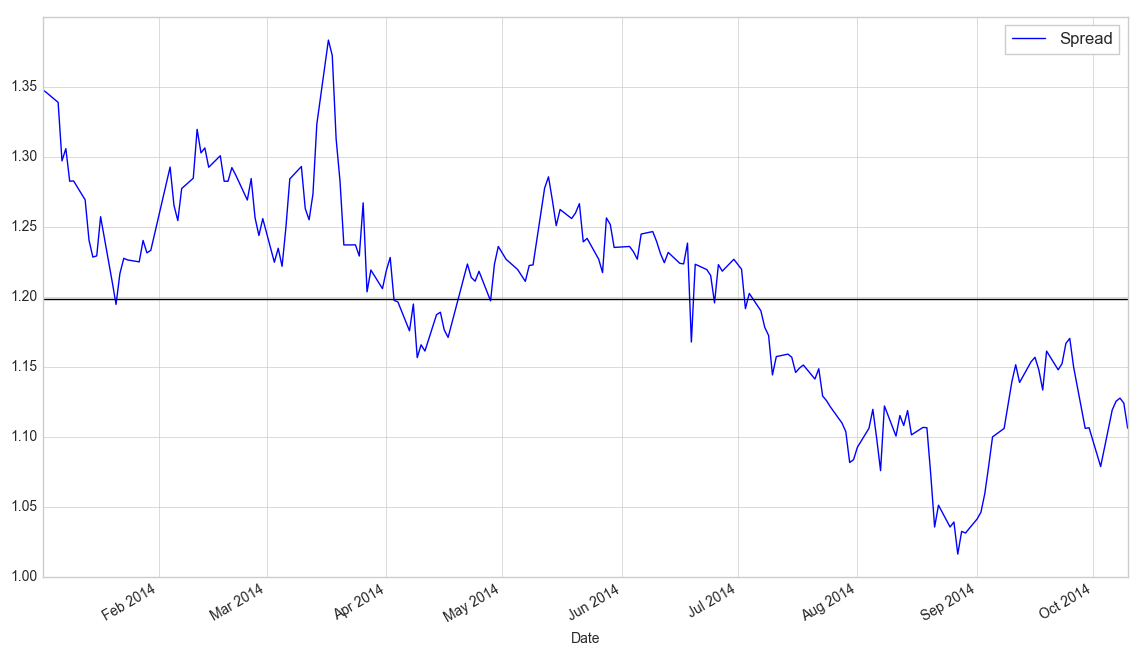

In [15]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['0960.HK']
b = results.params['0960.HK']

spread = S2 - b * S1
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

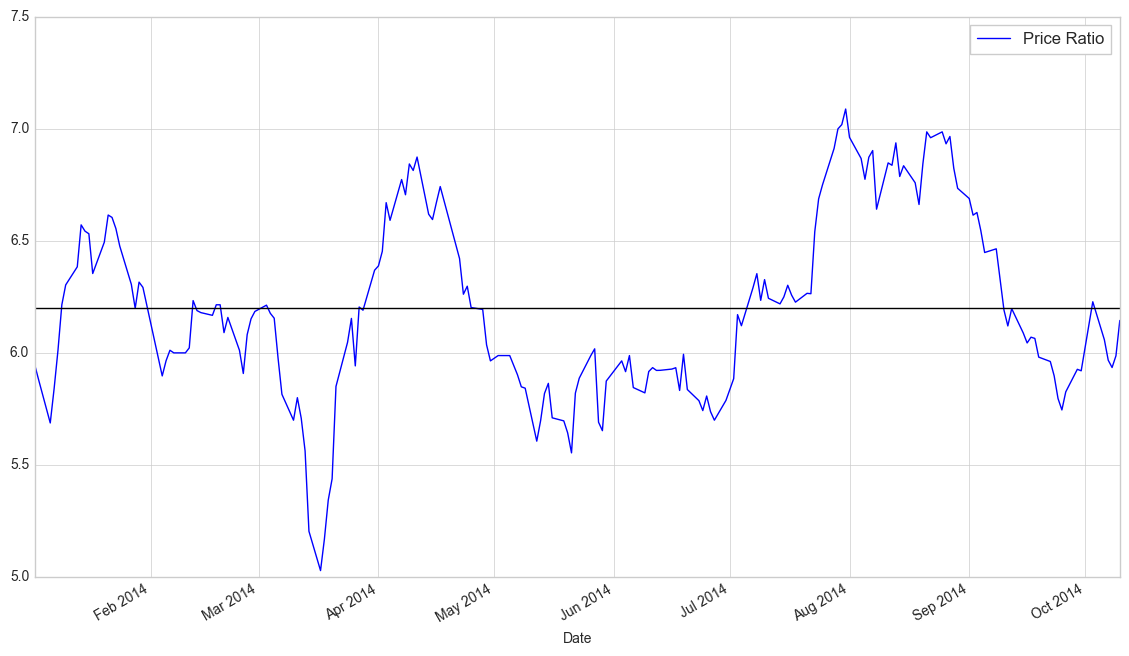

In [16]:
ratio = S1/S2
ratio.plot()
plt.axhline(ratio.mean(), color='black')
plt.legend(['Price Ratio']);

But purchasing the precisely correct ratio of a trading pair may not be practical. Actually, the absolute spread is not very useful in statistical terms. It is more helpful to normalize our signal by treating it as a z-score.

The z-score is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured. This conversion is known as *standardising* or *normalising* (in this context). Note however that this assumes some underlying distribution (usually normal), which is generally not the case with financial data. In practice we should not assume normality or any distribution without evidence to back it up.

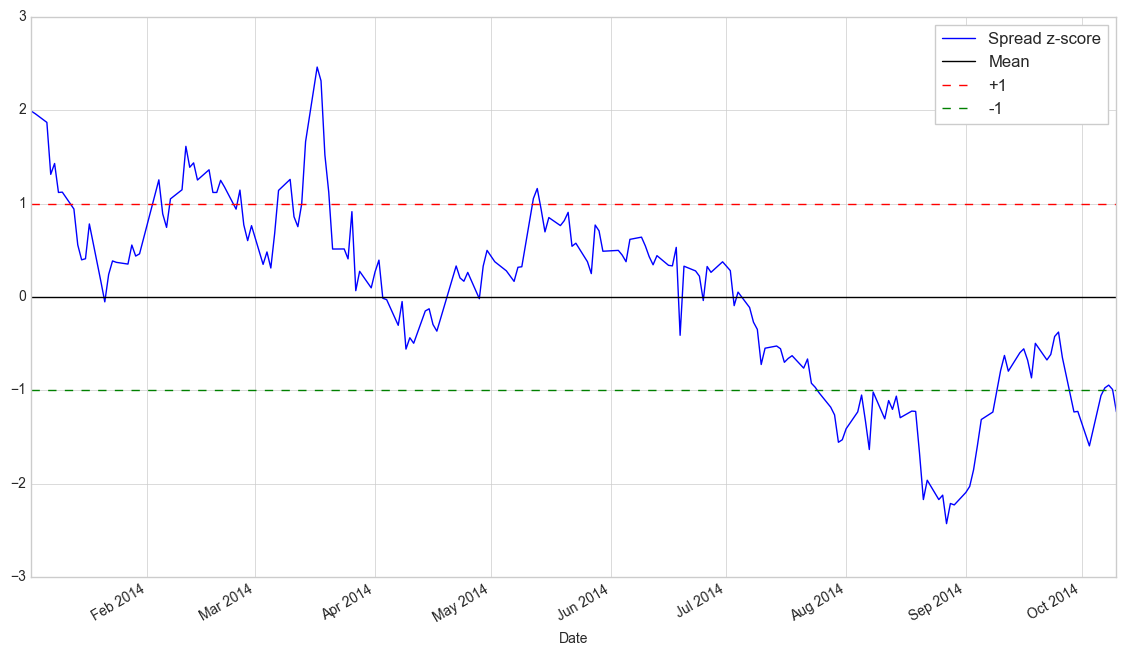

In [17]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

Using this, we then formulate the following strategy:
- Long the spread whenever z-score < -1.0
- Short the spread whenever z-score > 1.0 
- Exit positions when z-score approaches zero

Note that this is only a elementary formulation. In practice we will want to compute a more optimal weighting for the amount of shares to hold for S1 and S2. We can improve our decision-making by using statistics computed out of a rolling window. 

C:\Python27\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: The pandas.stats.ols module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://www.statsmodels.org/stable/regression.html
  app.launch_new_instance()


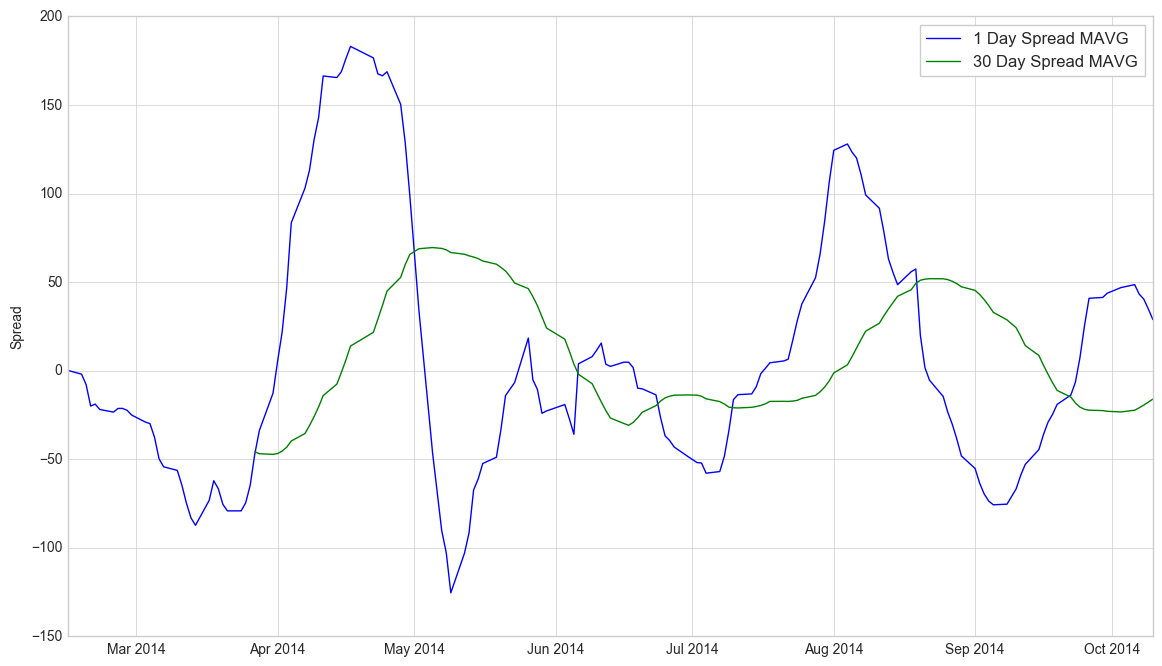

In [18]:
# Get the spread between the 2 stocks
# Calculate rolling beta coefficient
rolling_beta = pd.ols(y=S1, x=S2, window_type='rolling', window=30)
spread = S2 - rolling_beta.beta['x'] * S1
spread.name = 'spread'

# Get the 1 day moving average of the price spread
spread_mavg1 = spread.rolling(window=1,center=False).mean()
spread_mavg1.name = 'spread 1d mavg'

# Get the 30 day moving average
spread_mavg30 = spread.rolling(window=30,center=False).mean()
spread_mavg30.name = 'spread 30d mavg'

plt.plot(spread_mavg1.index, spread_mavg1.values)
plt.plot(spread_mavg30.index, spread_mavg30.values)

plt.legend(['1 Day Spread MAVG', '30 Day Spread MAVG'])

plt.ylabel('Spread');

Using these moving averages, we can compute the z-score of the spread at each given time. This will tell us how extreme the spread is and whether it's a good idea to enter a position at this time. The z-score does not mean much out of context however, so we plot it next to the prices to get an idea of what it looks like.

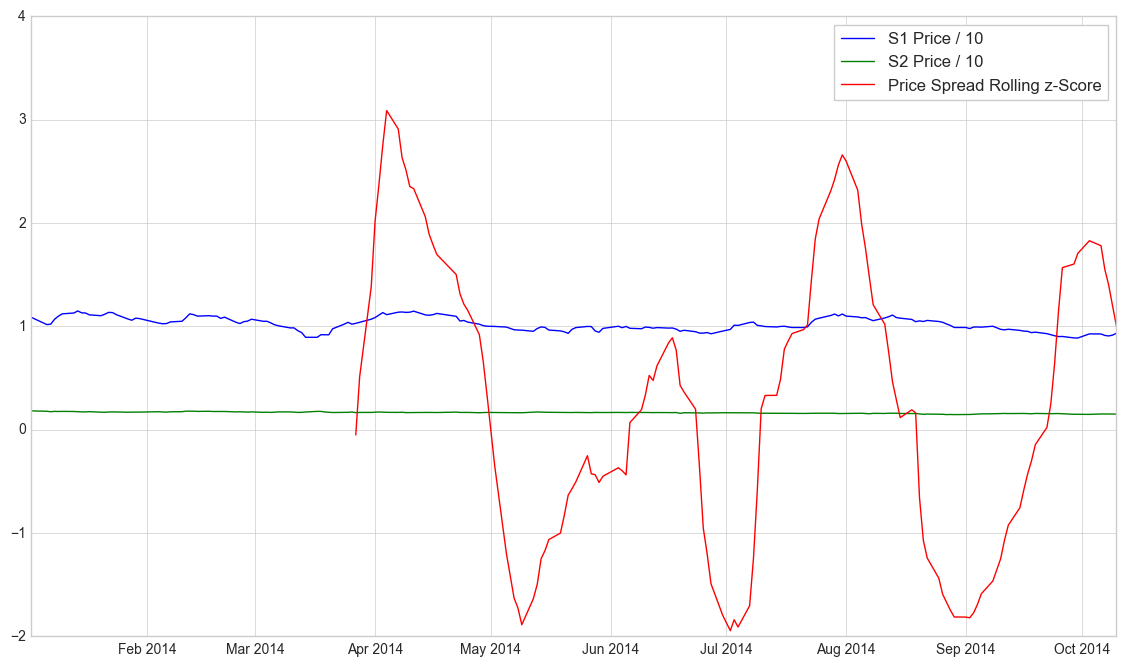

In [19]:
# Take a rolling 30 day standard deviation
std_30 = spread.rolling(window=30,center=False).std()
std_30.name = 'std 30d'

# Compute the z score for each day
zscore_30_1 = (spread_mavg1 - spread_mavg30)/std_30
zscore_30_1.name = 'z-score'

# Plot the prices scaled down along with the negative z-score
# just divide the stock prices by 10 to make viewing it on the plot easier
plt.plot(S1.index, S1.values/10)
plt.plot(S2.index, S2.values/10)
plt.plot(zscore_30_1.index, zscore_30_1.values)
plt.legend(['S1 Price / 10', 'S2 Price / 10', 'Price Spread Rolling z-Score']);

Finally we perform an out of sample test to see whether our cointegrated relationship holds for 2015-2016, so that we can have confidence in implementing it in forward time.

In [20]:
symbol_list = ['0960.HK','1966.HK']
prices = ut.get_pricing(symbol_list, src="yhoo", start_date='2015-01-01', end_date='2016-01-01', field='close').dropna()
S1 = prices['0960.HK']
S2 = prices['1966.HK']
score, pvalue, _ = coint(S1, S2)
pvalue

0.50340825914743748

This is greater than our cutoff value, so we conclude that our model will no longer be valid due to the lack of cointegration between our chosen securities.

## Position concentration risk

Diversification is a key concept in minimising risk. A diversified portfolio is much more likely to have a lower risk profile than a concentrated one. As an example, suppose we learned how to count cards in a blackjack game. This gives us a 1% edge over the house, yielding odds of 51:49. What is our strategy on betting $10,000 on the house?

Obviously we don't want to spend all our money on one game. So let's say we make independent bets on 100 different tables. In 1000 different universes, we have

In [21]:
universes = 1000

results = np.zeros((universes, 1))
for i in range(universes):
    results[i] = np.random.binomial(n = 100, p=0.51)

np.mean(results), np.std(results)

(50.950000000000003, 5.1899421962098966)

We see that with 100 games we have around 51 games won. This gives an expected edge of 1 game. Note that the standard deviation is several games, so there is still much room to lose (technically our data here is not normal so we should not be using the s.d. to make judgements. We will abuse its use here as it is the metric of volatility used in finance, and it still reflects how much 'spread' exists in the data).

Let us extend to 10000 games. This gives

In [22]:
universes = 1000

results = np.zeros((universes, 1))
for i in range(universes):
    results[i] = np.random.binomial(n = 10000, p=0.51)

np.mean(results), np.std(results)

(5099.5240000000003, 48.974497690124402)

We get an edge of ~100 games, which makes it safer.

The same principle can be applied to portfolio theory. If we are confident that a stock will go up or down, we should try to make as many independent bets as possible. This can be accomplished by investing in as many uncorrelated assets as possible. Recall that in finance, volatility is measured by the standard deviation of a time series, and the amount of future risk of a portfolio is estimated by past portfolio volatility.

Let us demonstrate diversification through the following example. We construct two portfolios, one consisting entirely of one asset and another with a collection of uncorrelated assets. In the first case, we're totally exposed to the volatility of that asset.

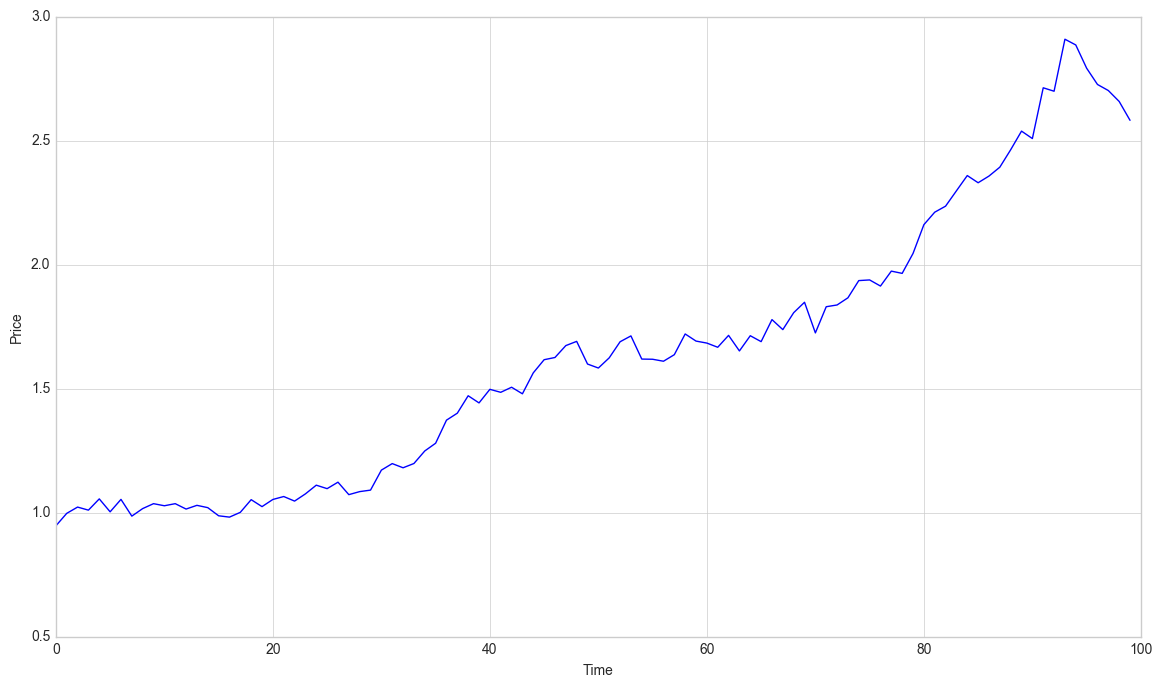

In [23]:
R_1 = np.random.normal(1.01, 0.03, 100)
A_1 = np.cumprod(R_1)
P = A_1
plt.plot(P)
plt.xlabel('Time')
plt.ylabel('Price');

Let us now independently generate a bunch of assets and construct a portfolio that combines all of them.

Asset Volatilities
[0.028597734605210954, 0.031591320146531363, 0.032344474117729199, 0.03207818846851871, 0.029020145649558588, 0.030661204626112288, 0.028150688080469898, 0.031979745118497001, 0.031507779643673246, 0.028578061321583983]
Mean Asset Volatility
0.0304509341778
Portfolio Volatility
0.0091586103007


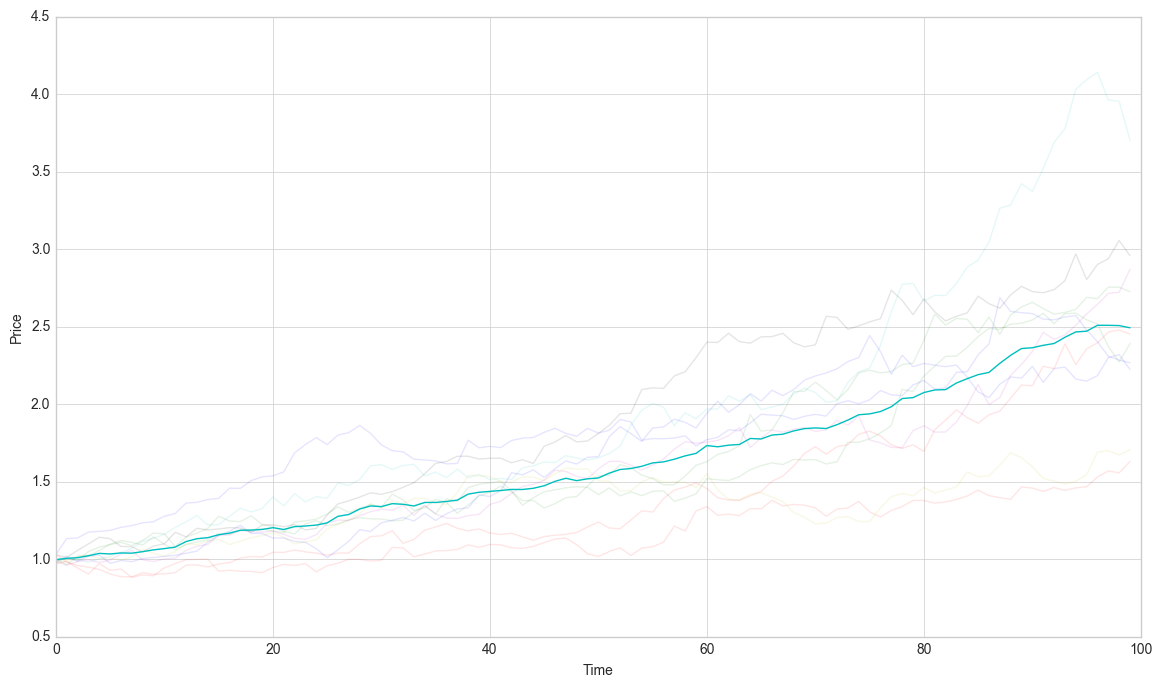

In [24]:
N = 10 # number of assets

assets = np.zeros((N, 100))
returns = np.zeros((N, 100))

for i in range(N):
    R_i = np.random.normal(1.01, 0.03, 100)
    returns[i] = R_i
    assets[i] = np.cumprod(R_i)
    
    plt.plot(assets[i], alpha=0.1)

R_P = np.mean(returns, axis=0)
P = np.mean(assets, axis=0)
plt.plot(P)
plt.xlabel('Time')
plt.ylabel('Price');

print 'Asset Volatilities'
print [np.std(R) for R in returns]
print 'Mean Asset Volatility'
print np.mean([np.std(R) for R in returns])
print 'Portfolio Volatility'
print np.std(R_P)

Thus we see that diversification smooths out our portfolio. The more (uncorrelated) assets we hold, the more we reduce our volatility. Note that correlated assets will not do this. It is the equivalent of making dependent bets to the original.

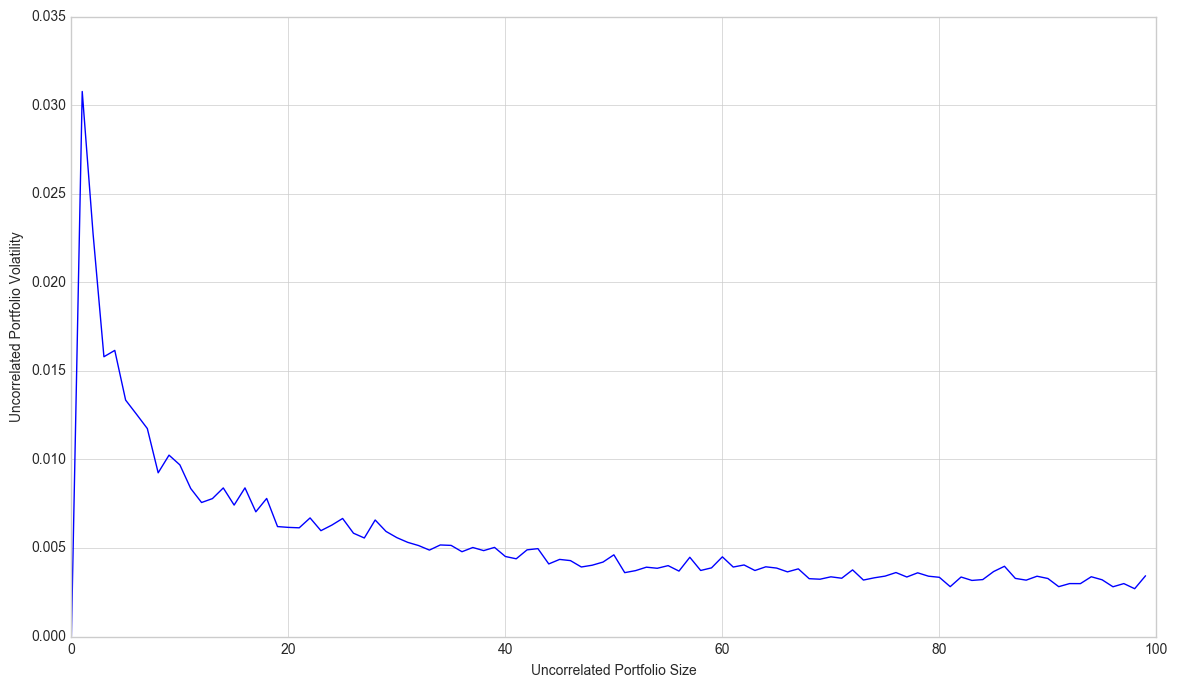

In [25]:
portfolio_volatilities_by_size = np.zeros((100,1))

for N in range(1,100):

    assets = np.zeros((N, 100))
    returns = np.zeros((N, 100))

    for i in range(N):
        R_i = np.random.normal(1.01, 0.03, 100)
        returns[i] = R_i

    R_P = np.mean(returns, axis=0)

    portfolio_volatilities_by_size[N] = np.std(R_P)
    
plt.plot(portfolio_volatilities_by_size)
plt.xlabel('Uncorrelated Portfolio Size')
plt.ylabel('Uncorrelated Portfolio Volatility');

Let us now explain the mathematical theory. Suppose we have two assets $S_1$, $S_2$ in a portfolio $P$. Assign them weights $w_1$, $w_2$ s.t. $w_1+w_2=1$. Let $S_1$, $S_2$ have mean and s.d. $\mu_1,\sigma_1$, $\mu_2,\sigma_2$ respectively.

The value of $P$ is then simply
$$
P=w_1S_1+w_2S_2\,.
$$
If $R_P$ is the return of portfolio $P$ and $R_i$ the return of assets $S_i$, then the expected return of the portfolio is
$$
\mathbb{E}[R_P]=\mathbb{E}[w_1 R_1+w_2R_2]=w_1\mathbb{E}[R_1]+w_2\mathbb{E}[R_2]\,.
$$
The variance of the portfolio is
$$
\begin{align}
\sigma^2_P&=\text{var}[P]\\
&=\text{var}[w_1S_1+w_2S_2]\\
&=\text{var}[w_1S_1]+\text{var}[w_2S_2]+w_1w_2\text{cov}[S_1,S_2]\\
&=w_1^2\text{var}[S_1]+w_2^2\text{var}[S_2]+w_1w_2\text{cov}[S_1,S_2]\\
&=w_1^2\sigma_1^2+w_2^2\sigma_2^2+\rho_{12}w_1w_2\sigma_1\sigma_2\,,
\end{align}
$$
where $\rho_{12}=\text{corr}[S_1,S_2]=\frac{\text{cov}[S_1,S_2]}{\sigma_1\sigma_2}$.

In [26]:
stocks = np.array([100, 75])
mean_returns = np.array([4, 6])

r_12 = 0.20
cov_12 = r_12 * 0.05 * 0.08
covariance_matrix = np.array([[0.05**2,cov_12],[cov_12,0.08**2]])

weights = np.array([0.7, 0.3])

P = np.dot(weights, stocks.T)

var_p = np.dot(np.dot(weights, covariance_matrix), weights.T)
sigma_p = np.sqrt(var_p)
print "The overall risk of the portfolio is: ", sigma_p

The overall risk of the portfolio is:  0.0462276973253


We can generalise to a portfolio made of $n$ securities fairly easily. The variance of a portfolio with $n$ assets is
$$
\sigma_P^2=\sum_iw_i^2\sigma_i^2+\sum_i\sum_{j\neq i}w_iw_j\sigma_i\sigma_j\rho_{ij}\,,\qquad i,j\in{1,...,n}
$$
By ensuring our assets are independent, or more or less uncorrelated, we bring $\rho_{ij}$ closer to zero.

In [27]:
stocks = np.array([230, 176, 192, 105])
mean_returns = np.array([2.0, 3.5, 7.5, 5.0])
std_dev = np.array([0.05, 0.07, 0.11, 0.09])
weights = np.array([0.35, 0.30, 0.15, 0.20])


r_12 = 0.2
r_13 = 0.08
r_14 = 0.1
r_23 = 0.6
r_24 = 0.4
r_34 = 0.8
covariance_matrix = np.array([[0.05**2, r_12 * 0.05 * 0.07, r_13 * 0.05 * 0.11, r_14 * 0.05 * 0.09],
                             [r_12 * 0.05 * 0.07, 0.07**2, r_23 * 0.07 * 0.11, r_24 * 0.07 * 0.09],
                             [r_13 * 0.05 * 0.11, r_23 * 0.07 * 0.11, 0.11**2, r_34 * 0.11 * 0.09],
                             [r_14 * 0.05 * 0.09, r_24 * 0.07 * 0.09, r_34 * 0.11 * 0.09, 0.09**2]])

var_p = np.dot(np.dot(weights, covariance_matrix), weights.T)
sigma_p = np.sqrt(var_p)
print "The overall risk of the portfolio is: ", sigma_p

The overall risk of the portfolio is:  0.052849787133
